In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
pd.set_option('display.max_columns',500)
pd.set_option('display.width',500)
pd.set_option('display.max_rows', 500)

### Importing requried libraries

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [5]:
train_data = pd.read_csv('../input/titanic/train.csv')
test_data = pd.read_csv('../input/titanic/test.csv')

In [6]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [8]:
100*len(test_data)/len(train_data)

46.91358024691358

In [9]:
train_data.shape, test_data.shape

((891, 12), (418, 11))

### Information of dataset

In [10]:
def details(df):
    missing_values = df.isnull().sum()
    missing_perc = 100*df.isnull().sum()/len(df)
    data_types = df.dtypes
    unique_vlaues = df.nunique()
    
    table = pd.concat([missing_values,missing_perc,data_types,unique_vlaues], axis=1)
    table_columns = table.rename(columns = {0 : 'Missing Values', 1 : '% of Total Missing Values', 2 : 'Data_Types', 3: 'Unique values'})
    return table_columns

In [11]:
details(train_data)

,Missing Values,% of Total Missing Values,Data_Types,Unique values
PassengerId,0,0.000000,int64,891
Survived,0,0.000000,int64,2
Pclass,0,0.000000,int64,3
Name,0,0.000000,object,891
Sex,0,0.000000,object,2
Age,177,19.865320,float64,88
SibSp,0,0.000000,int64,7
Parch,0,0.000000,int64,7
Ticket,0,0.000000,object,681
Fare,0,0.000000,float64,248


In [12]:
details(test_data)

,Missing Values,% of Total Missing Values,Data_Types,Unique values
PassengerId,0,0.000000,int64,418
Pclass,0,0.000000,int64,3
Name,0,0.000000,object,418
Sex,0,0.000000,object,2
Age,86,20.574163,float64,79
SibSp,0,0.000000,int64,7
Parch,0,0.000000,int64,8
Ticket,0,0.000000,object,363
Fare,1,0.239234,float64,169
Cabin,327,78.229665,object,76


### Balance of Data

In [13]:
100*train_data['Survived'].value_counts(normalize=True)

0    61.616162
1    38.383838
Name: Survived, dtype: float64

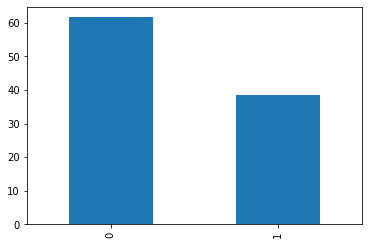

In [14]:
round(100*train_data['Survived'].value_counts(normalize=True),2).plot(kind='bar', figsize=(6,4))
plt.show()

### Male vs Female Surviours

In [15]:
women = train_data.loc[train_data.Sex == 'female']["Survived"]
rate_women = sum(women)/len(women)

print("% of women who survived:", rate_women)

% of women who survived: 0.7420382165605095


In [16]:
men = train_data.loc[train_data.Sex == 'male']["Survived"]
rate_men = sum(men)/len(men)

print("% of men who survived:", rate_men)

% of men who survived: 0.18890814558058924


In [17]:
train_data.describe(percentiles=[0.01,0.1,0.25,0.5,0.75,0.9,0.95,0.99])

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
1%,9.900000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
10%,90.000000,0.000000,1.000000,14.000000,0.000000,0.000000,7.550000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
90%,802.000000,1.000000,3.000000,50.000000,1.000000,2.000000,77.958300


In [18]:
test_data.describe(percentiles=[0.01,0.1,0.25,0.5,0.75,0.9,0.95,0.99])

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
1%,896.170000,1.000000,0.857900,0.000000,0.000000,6.446828
10%,933.700000,1.000000,16.100000,0.000000,0.000000,7.641680
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
90%,1267.300000,3.000000,50.000000,1.000000,1.300000,79.200000


### Dropping cabin column from both train and test dataset

In [19]:
train_data.drop('Cabin', axis=1, inplace=True)
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


In [20]:
test_data.drop('Cabin', axis=1, inplace=True)
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,S


### Imputing Age, Fare and Embarked with median and mode values

In [21]:
age_median_train = train_data.Age.median()
train_data.Age.fillna(age_median_train, inplace=True)
train_data.Age.isnull().sum()

0

In [22]:
age_median_test = test_data.Age.median()
test_data.Age.fillna(age_median_test, inplace=True)
test_data.Age.isnull().sum()

0

In [23]:
train_data.SibSp.value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

In [24]:
train_data.Parch.value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

In [25]:
train_data.Embarked.value_counts(dropna=False)

S      644
C      168
Q       77
NaN      2
Name: Embarked, dtype: int64

In [26]:
Embarked_mode_train = train_data.Embarked.mode()[0]
train_data.Embarked.fillna(Embarked_mode_train, inplace=True)
train_data.Embarked.isnull().sum()

0

In [27]:
Fare_median_test = test_data.Fare.median()
test_data.Fare.fillna(Fare_median_test, inplace=True)
test_data.Fare.isnull().sum()

0

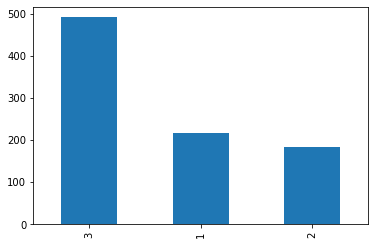

In [28]:
train_data.Pclass.value_counts().plot(kind='bar')

In [29]:
train_data.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C


In [30]:
test_data.head(2)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,S


In [31]:
details(train_data)

,Missing Values,% of Total Missing Values,Data_Types,Unique values
PassengerId,0,0.0,int64,891
Survived,0,0.0,int64,2
Pclass,0,0.0,int64,3
Name,0,0.0,object,891
Sex,0,0.0,object,2
Age,0,0.0,float64,88
SibSp,0,0.0,int64,7
Parch,0,0.0,int64,7
Ticket,0,0.0,object,681
Fare,0,0.0,float64,248


In [32]:
details(test_data)

,Missing Values,% of Total Missing Values,Data_Types,Unique values
PassengerId,0,0.0,int64,418
Pclass,0,0.0,int64,3
Name,0,0.0,object,418
Sex,0,0.0,object,2
Age,0,0.0,float64,79
SibSp,0,0.0,int64,7
Parch,0,0.0,int64,8
Ticket,0,0.0,object,363
Fare,0,0.0,float64,169
Embarked,0,0.0,object,3


### Checking outliers in Fare, Parch, SibSp

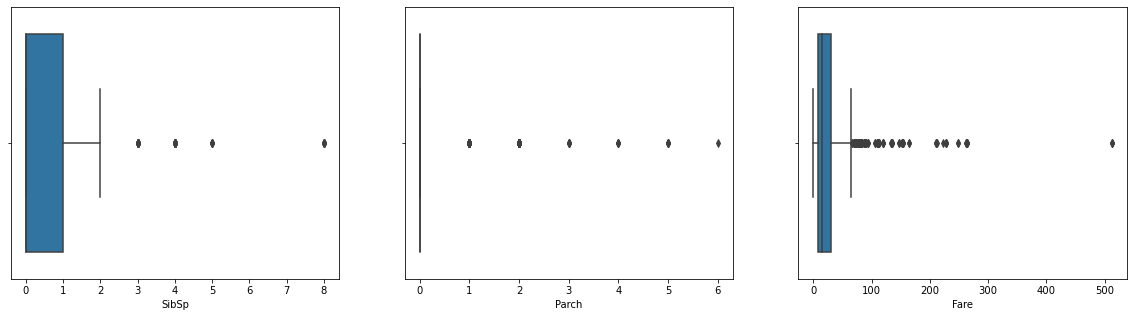

In [33]:
col_data_train = ['SibSp','Parch','Fare']

plt.figure(figsize=(20,5))
for i in enumerate(col_data_train):
    plt.subplot(1,3,i[0]+1)
    sns.boxplot(train_data[i[1]])

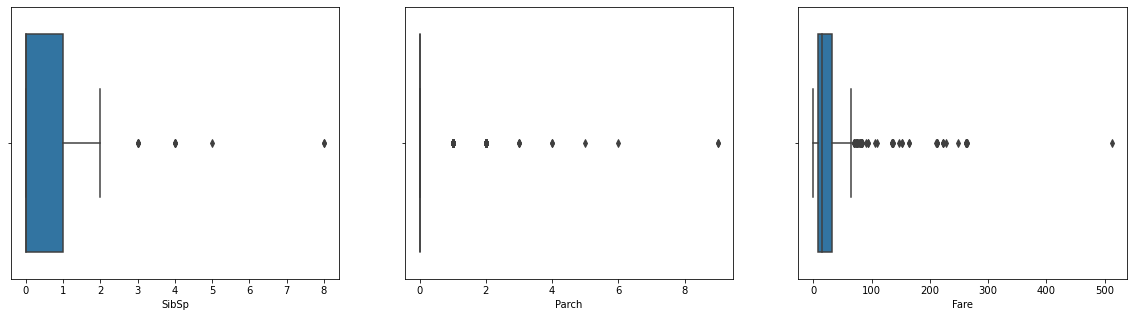

In [34]:
col_data_test = ['SibSp','Parch','Fare']

plt.figure(figsize=(20,5))
for i in enumerate(col_data_test):
    plt.subplot(1,3,i[0]+1)
    sns.boxplot(test_data[i[1]])

### Splitting and joining columns

In [35]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


In [36]:
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,S


In [37]:
train_data['Family_size'] = train_data['SibSp'] + train_data['Parch'] + 1
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Family_size
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,2
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,1


In [38]:
test_data['Family_size'] = test_data['SibSp'] + test_data['Parch'] + 1
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Family_size
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Q,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,S,2
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Q,1
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,S,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,S,3


In [39]:
train_data.drop(['SibSp','Parch','Ticket'], axis=1, inplace=True)
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,Fare,Embarked,Family_size
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,7.2500,S,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,71.2833,C,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,7.9250,S,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,53.1000,S,2
4,5,0,3,"Allen, Mr. William Henry",male,35.0,8.0500,S,1


In [40]:
test_data.drop(['SibSp','Parch','Ticket'], axis=1, inplace=True)
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,Fare,Embarked,Family_size
0,892,3,"Kelly, Mr. James",male,34.5,7.8292,Q,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,7.0000,S,2
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,9.6875,Q,1
3,895,3,"Wirz, Mr. Albert",male,27.0,8.6625,S,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,12.2875,S,3


In [41]:
train_data.Family_size.value_counts(dropna=False)

1     537
2     161
3     102
4      29
6      22
5      15
7      12
11      7
8       6
Name: Family_size, dtype: int64

In [42]:
test_data.Family_size.value_counts(dropna=False)

1     253
2      74
3      57
4      14
5       7
11      4
7       4
6       3
8       2
Name: Family_size, dtype: int64

### OHE

In [43]:
ohe = OneHotEncoder(sparse=False, drop='first', dtype=int)

In [44]:
ohe_df1 = pd.DataFrame(ohe.fit_transform(train_data[['Sex','Embarked']]),columns=ohe.get_feature_names())
ohe_df2 = pd.DataFrame(ohe.transform(test_data[['Sex','Embarked']]),columns=ohe.get_feature_names())

In [45]:
train_data = pd.concat([train_data, ohe_df1],1)
test_data = pd.concat([test_data, ohe_df2],1)

In [46]:
# For train data
train_data.drop(['Sex','Embarked', 'Name'],1, inplace=True)

# For test data
test_data.drop(['Sex','Embarked', 'Name'],1, inplace=True)

### Saving original dataset

In [47]:
df_train = train_data.copy()
df_test = test_data.copy()

### Data prep for Logistic Regression

In [48]:
bins_age = [0, 12, 18, 35, 60, 100]
labels_age = ['Child','Teen','Young_Adult','Adult','Senior']
df_train['age_bins'] = pd.cut(df_train['Age'], bins=bins_age, labels=labels_age)
df_test['age_bins'] = pd.cut(df_test['Age'], bins=bins_age, labels=labels_age)

In [49]:
df_train.drop('Age',1, inplace=True)
df_test.drop('Age',1, inplace=True)

### Ordinal encoding for age_bins

In [50]:
age_bins = ['Child','Teen','Young_Adult','Adult','Senior']
ordi = OrdinalEncoder(categories=[age_bins], dtype=int)
df_train['age_bins'] = pd.DataFrame(ordi.fit_transform(df_train[['age_bins']]))
df_test['age_bins'] = pd.DataFrame(ordi.transform(df_test[['age_bins']]))

### HeatMap

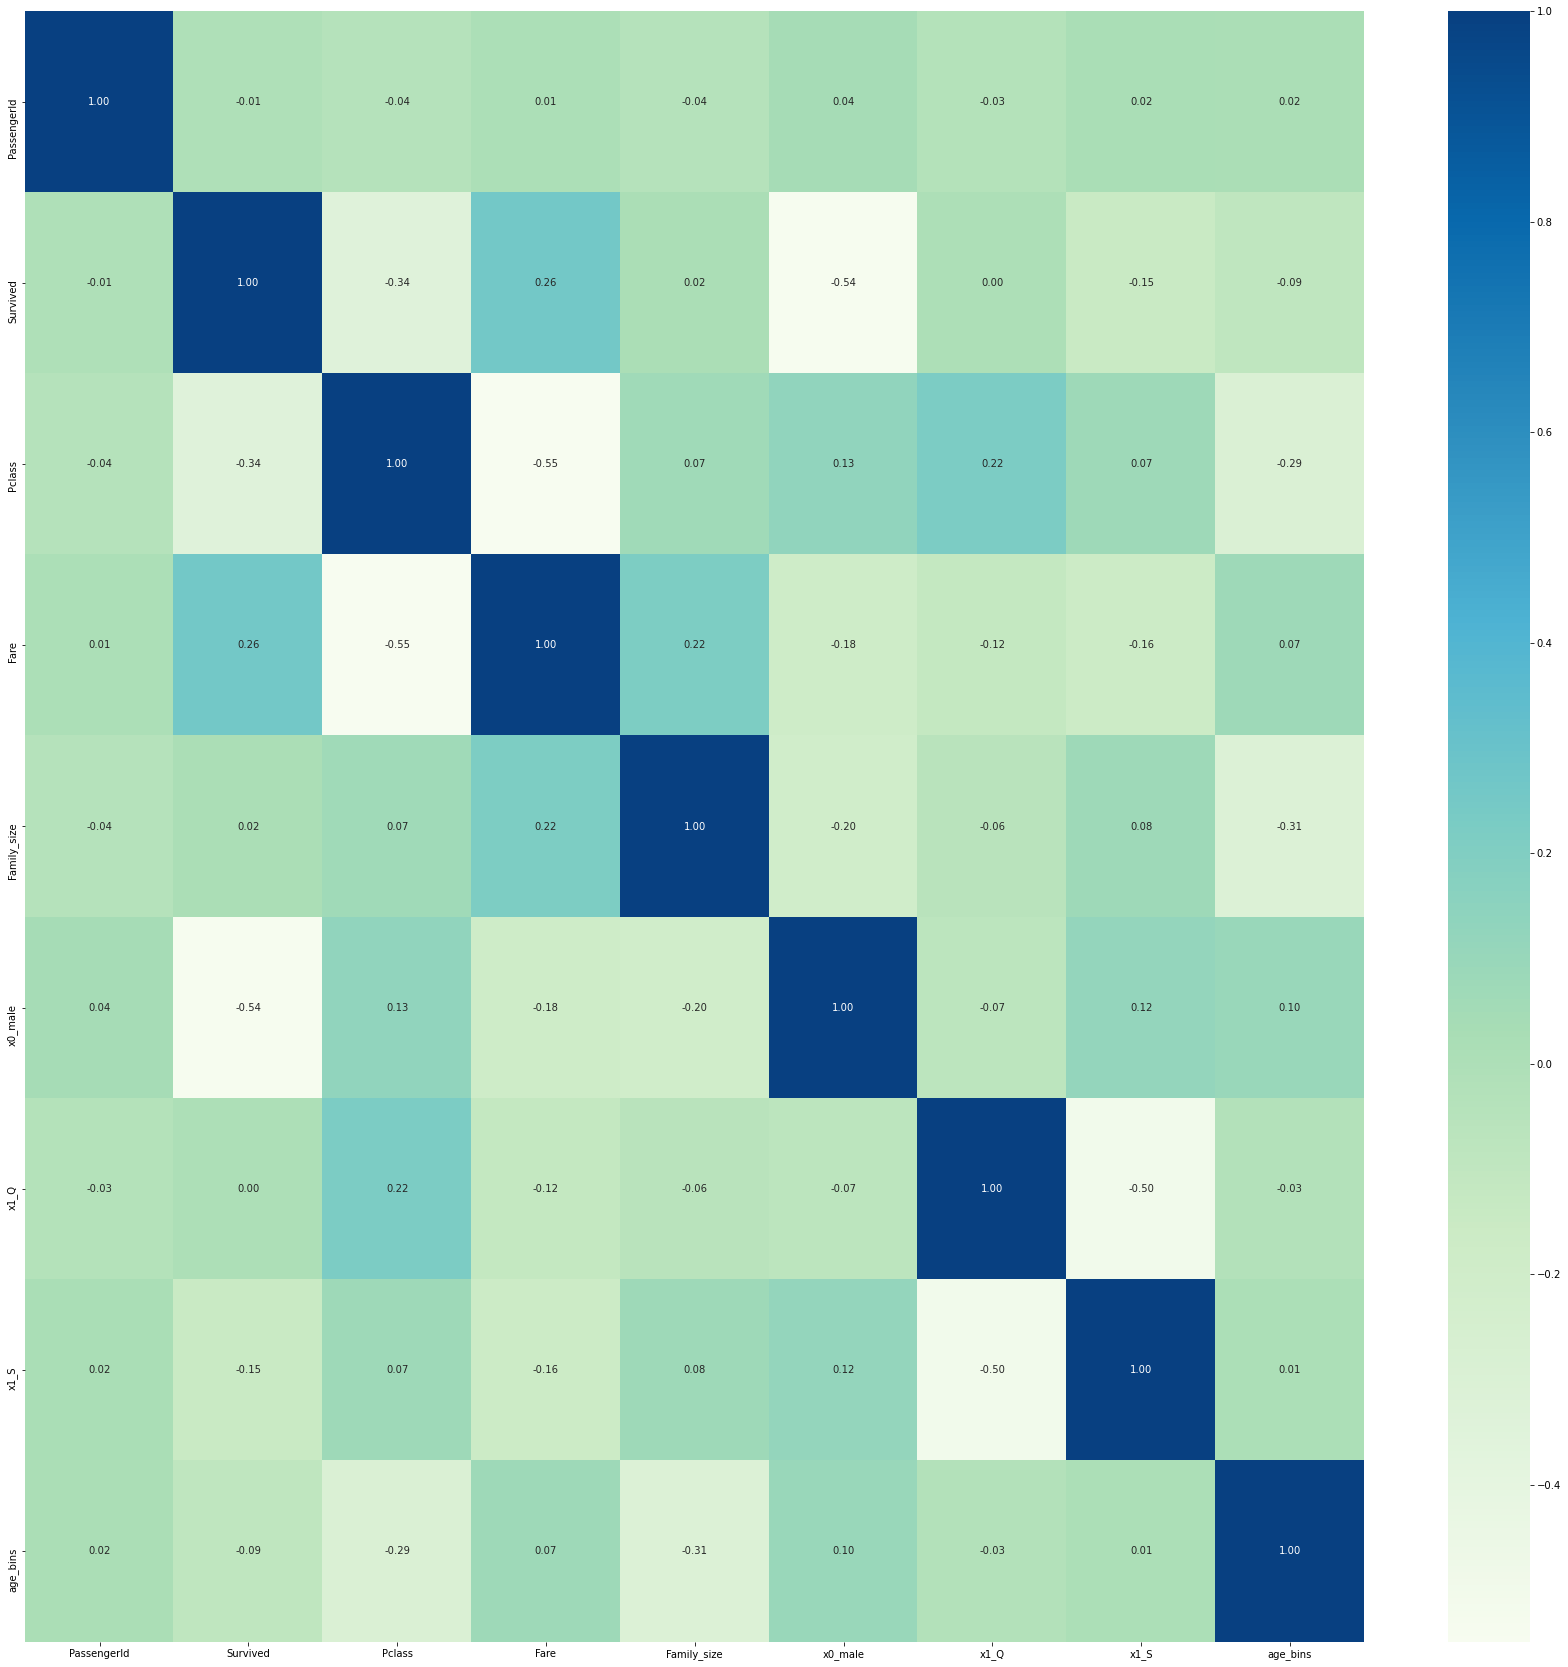

In [51]:
plt.figure(figsize = (30,30))
sns.heatmap(df_train.corr(),annot = True, cmap="GnBu",fmt='.2f')
plt.show()

In [52]:
corr_matrix_train = df_train.corr().abs()

# Select upper triangle of correlation matrix
upper_train = corr_matrix_train.where(np.triu(np.ones(corr_matrix_train.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.8 as they are highly correlated
to_drop_train = [column for column in upper_train.columns if any(upper_train[column] > 0.7)]
to_drop_train

[]

### Splitting the data

In [53]:
df_train.head()

,PassengerId,Survived,Pclass,Fare,Family_size,x0_male,x1_Q,x1_S,age_bins
0,1,0,3,7.2500,2,1,0,1,2
1,2,1,1,71.2833,2,0,0,0,3
2,3,1,3,7.9250,1,0,0,1,2
3,4,1,1,53.1000,2,0,0,1,2
4,5,0,3,8.0500,1,1,0,1,2


In [54]:
df_test.head()

,PassengerId,Pclass,Fare,Family_size,x0_male,x1_Q,x1_S,age_bins
0,892,3,7.8292,1,1,1,0,2
1,893,3,7.0000,2,0,0,1,3
2,894,2,9.6875,1,1,1,0,4
3,895,3,8.6625,1,1,0,1,2
4,896,3,12.2875,3,0,0,1,2


In [55]:
X = df_train.drop(['PassengerId','Survived'],1)
y = df_train['Survived']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=23)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((623, 7), (268, 7), (623,), (268,))

### Scaling

In [56]:
scaler = StandardScaler()
X_train[['Pclass', 'Fare', 'Family_size']] = scaler.fit_transform(X_train[['Pclass', 'Fare', 'Family_size']])
X_val[['Pclass', 'Fare', 'Family_size']] = scaler.transform(X_val[['Pclass', 'Fare', 'Family_size']])

 ### Model Building

In [57]:
# Models
model_algos = []
# accuracy
train_accuracy = []
val_accuracy = []

### Logistic Regression without hyperparameters

In [58]:
model_LR = LogisticRegression()

In [59]:
def model_fit(model, X_train, y_train, X_val, y_val, algo=None):
    
    model_LR.fit(X_train, y_train)
    
    y_train_pred= model_LR.predict(X_train)
    y_val_pred = model_LR.predict(X_val)
    acc_train = accuracy_score(y_train, y_train_pred)
    acc_val = accuracy_score(y_val, y_val_pred)
    matrix_train = confusion_matrix(y_train, y_train_pred)
    matrix_val = confusion_matrix(y_val, y_val_pred)
    
    print('Confusion Matrix train')
    print('='*60)
    print(matrix_train,"\n")
    print('Confusion Matrix validation')
    print('='*60)
    print(matrix_val,"\n")
    print('Accuracy of training set')
    print('='*60)
    print(acc_train)
    print('='*60)
    print('Accuracy of validation set')
    print('='*60)
    print(acc_val)
    
    model_algos.append(algo)
    train_accuracy.append(acc_train)
    val_accuracy.append(acc_val)

In [60]:
model_fit(model_LR, X_train, y_train, X_val, y_val, algo='LR without HPT')

Confusion Matrix train
[[325  51]
 [ 65 182]] 

Confusion Matrix validation
[[142  31]
 [ 32  63]] 

Accuracy of training set
0.8138041733547352
Accuracy of validation set
0.7649253731343284


In [61]:
params_LR = {'C':np.logspace(-1, 5, 10), 'class_weight':[None,'balanced'], 'penalty':['l1','l2']}

In [62]:
def model_fit_evaluation(model, params, X_train, y_train, X_val, y_val, algo=None):
        
    rcv = RandomizedSearchCV(model, params, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1, random_state=23)
    rcv.fit(X_train, y_train)
    
    print('\n')
    print('best estimator : ', rcv.best_estimator_)
    print('best parameters: ', rcv.best_params_)
    print('best score: ', rcv.best_score_)
    print('\n')

    # Prediction    
    y_train_pred=(rcv.best_estimator_).predict(X_train)
    y_val_pred=(rcv.best_estimator_).predict(X_val)
    acc_train = accuracy_score(y_train, y_train_pred)
    acc_val = accuracy_score(y_val, y_val_pred)
    matrix_train = confusion_matrix(y_train, y_train_pred)
    matrix_val = confusion_matrix(y_val, y_val_pred)
    
    print('Confusion Matrix train')
    print('='*60)
    print(matrix_train,"\n")
    print('Confusion Matrix validation')
    print('='*60)
    print(matrix_val,"\n")
    print('Accuracy of training set')
    print('='*60)
    print(acc_train)
    print('='*60)
    print('Accuracy of validation set')
    print('='*60)
    print(acc_val)    
        
    model_algos.append(algo)
    train_accuracy.append(acc_train)
    val_accuracy.append(acc_val)

In [63]:
model_fit_evaluation(model_LR, params_LR, X_train, y_train, X_val, y_val, algo='LR with HPT')

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.




best estimator :  LogisticRegression(C=0.1, class_weight='balanced')
best parameters:  {'penalty': 'l2', 'class_weight': 'balanced', 'C': 0.1}
best score:  0.8663065520945221


Confusion Matrix train
[[310  66]
 [ 50 197]] 

Confusion Matrix validation
[[133  40]
 [ 27  68]] 

Accuracy of training set
0.8138041733547352
Accuracy of validation set
0.75


[Parallel(n_jobs=-1)]: Done  43 out of  50 | elapsed:    2.0s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.1s finished


### Decision Tree

In [64]:
train_dt = train_data.copy()
test_dt = test_data.copy()

In [65]:
X = train_dt.drop(['PassengerId','Survived'],1)
y = train_dt['Survived']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=23)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((623, 7), (268, 7), (623,), (268,))

In [66]:
model_DT = DecisionTreeClassifier(random_state=23)
# model_DT.fit(X_train, y_train)
# y_train_pred= model_DT.predict(X_train)
# y_val_pred = model_DT.predict(X_val)
# acc_train = accuracy_score(y_train, y_train_pred)
# acc_val = accuracy_score(y_val, y_val_pred)
# print('Accuracy of training set')
# print('='*60)
# print(acc_train)
# print('='*60)
# print('Accuracy of validation set')
# print('='*60)
# print(acc_val)

In [67]:
model_fit(model_DT, X_train, y_train, X_val, y_val, algo='DT without HPT')

Confusion Matrix train
[[326  50]
 [ 67 180]] 

Confusion Matrix validation
[[141  32]
 [ 33  62]] 

Accuracy of training set
0.812199036918138
Accuracy of validation set
0.7574626865671642


In [68]:
params_DT = {
    'max_depth': [10, 20, 50, 100, 200],
    'min_samples_leaf': [10, 20, 50, 100, 200],
    'min_samples_split' : [10, 20, 50, 100, 200],
    'criterion': ["gini", "entropy"]
}

In [69]:
model_fit_evaluation(model_DT, params_DT, X_train, y_train, X_val, y_val, algo='DT with HPT')

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.




best estimator :  DecisionTreeClassifier(criterion='entropy', max_depth=100, min_samples_leaf=20,
                       min_samples_split=20, random_state=23)
best parameters:  {'min_samples_split': 20, 'min_samples_leaf': 20, 'max_depth': 100, 'criterion': 'entropy'}
best score:  0.851818575008951


Confusion Matrix train
[[341  35]
 [ 73 174]] 

Confusion Matrix validation
[[153  20]
 [ 36  59]] 

Accuracy of training set
0.826645264847512
Accuracy of validation set
0.7910447761194029


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished


### Random Forest

In [70]:
train_rf = train_data.copy()
test_rf = test_data.copy()

In [71]:
X = train_rf.drop(['PassengerId','Survived'],1)
y = train_rf['Survived']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=23)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((623, 7), (268, 7), (623,), (268,))

In [72]:
model_RF = RandomForestClassifier(random_state=23)
# model_RF.fit(X_train, y_train)
# y_train_pred= model_RF.predict(X_train)
# y_val_pred = model_RF.predict(X_val)
# acc_train = accuracy_score(y_train, y_train_pred)
# acc_val = accuracy_score(y_val, y_val_pred)
# print('Accuracy of training set')
# print('='*60)
# print(acc_train)
# print('='*60)
# print('Accuracy of validation set')
# print('='*60)
# print(acc_val)

In [73]:
model_fit(model_RF, X_train, y_train, X_val, y_val, algo='RF without HPT')

Confusion Matrix train
[[326  50]
 [ 67 180]] 

Confusion Matrix validation
[[141  32]
 [ 33  62]] 

Accuracy of training set
0.812199036918138
Accuracy of validation set
0.7574626865671642


In [74]:
params_RF = {
    'n_estimators': [10, 20, 50, 100, 200],
    'max_depth': [10, 20, 50, 100, 200],
    'min_samples_leaf': [10, 20, 50, 100, 200],
    'min_samples_split' : [10, 20, 50, 100, 200],
    'criterion': ["gini", "entropy"]
}

In [75]:
model_fit_evaluation(model_RF, params_RF, X_train, y_train, X_val, y_val, algo='RF with HPT')

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  43 out of  50 | elapsed:    1.9s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.2s finished




best estimator :  RandomForestClassifier(max_depth=10, min_samples_leaf=20, min_samples_split=50,
                       n_estimators=200, random_state=23)
best parameters:  {'n_estimators': 200, 'min_samples_split': 50, 'min_samples_leaf': 20, 'max_depth': 10, 'criterion': 'gini'}
best score:  0.8598014035087719


Confusion Matrix train
[[358  18]
 [ 90 157]] 

Confusion Matrix validation
[[162  11]
 [ 42  53]] 

Accuracy of training set
0.826645264847512
Accuracy of validation set
0.8022388059701493


In [76]:
eval_df = pd.DataFrame({'model': model_algos, 'train_acc': train_accuracy, 'val_acc': val_accuracy})
eval_df

,model,train_acc,val_acc
0,LR without HPT,0.813804,0.764925
1,LR with HPT,0.813804,0.750000
2,DT without HPT,0.812199,0.757463
3,DT with HPT,0.826645,0.791045
4,RF without HPT,0.812199,0.757463
5,RF with HPT,0.826645,0.802239


### Running again with Random forest with perfect parameters on entire train set

In [77]:
# model_RF = RandomForestClassifier( n_estimators=200, criterion: 'gini', max_depth=10, min_samples_split=50, min_samples_leaf=20, n_jobs=-1, random_state=23, verbose=1)
rcv = RandomizedSearchCV(model_RF, params_RF, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1, random_state=23)
rcv.fit(X, y)

print('\n')
print('best estimator : ', rcv.best_estimator_)
print('best parameters: ', rcv.best_params_)
print('best score: ', rcv.best_score_)
print('\n')

# Prediction    
y_train_pred=(rcv.best_estimator_).predict(X)
acc_train = accuracy_score(y, y_train_pred)
matrix_train = confusion_matrix(y, y_train_pred)

print('Confusion Matrix train')
print('='*60)
print(matrix_train,"\n")
print('Accuracy of training set')
print('='*60)
print(acc_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  43 out of  50 | elapsed:    2.0s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.3s finished




best estimator :  RandomForestClassifier(max_depth=10, min_samples_leaf=20, min_samples_split=50,
                       n_estimators=200, random_state=23)
best parameters:  {'n_estimators': 200, 'min_samples_split': 50, 'min_samples_leaf': 20, 'max_depth': 10, 'criterion': 'gini'}
best score:  0.8556053229211328


Confusion Matrix train
[[520  29]
 [120 222]] 

Accuracy of training set
0.8327721661054994


We can see here that train accuracy for whole training data set is 0.83 with ROC of 0.86.

### Feature importance variable using Random forest with hyperparameter tuning

In [78]:
feature = rcv.best_estimator_
feature.feature_importances_

array([0.15866381, 0.07040665, 0.16812089, 0.06791769, 0.50650109,
       0.00707958, 0.02131029])

In [79]:
final_df = pd.DataFrame({'Varname': X.columns, 'feature_imp':feature.feature_importances_})
final_df.sort_values(by='feature_imp', ascending=False)

,Varname,feature_imp
4,x0_male,0.506501
2,Fare,0.168121
0,Pclass,0.158664
1,Age,0.070407
3,Family_size,0.067918
6,x1_S,0.021310
5,x1_Q,0.007080


### Creating submission file

In [80]:
#Final prediction
predictions = rcv.predict(test_data.drop('PassengerId', axis=1))

#set the output as a dataframe and convert to csv file named submission.csv
submission = pd.DataFrame({ 'PassengerId' : test_data['PassengerId'], 'Survived': predictions })
submission.shape

(418, 2)

In [81]:
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [82]:
filename = 'Titanic_Predictions.csv'
submission.to_csv(filename, index=False)
print('Saved file: '+filename)

Saved file: Titanic_Predictions.csv
